# Matrix Multiplication using Cuda

In [1]:
%pylab inline
from numba import cuda, vectorize
import numpy as np
import math
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [40]:
k = 7
n = 2**k
m = 2**k
a = np.arange(n*m).reshape((n,m))
b = np.arange(n*m).reshape((n,m))
a.shape

(128, 128)

In [41]:
c = a.dot(b)
c.dtype

dtype('int32')

In [3]:
@cuda.jit
def matmul(A, B, C):
    """Perform square matrix multiplication of C = A * B"""
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

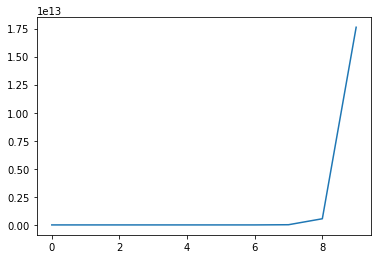

In [14]:
max_error = []
k_max = 10
for k in range(k_max):
    n = 2**k
    m = 2**k
    a = np.arange(n*m).reshape((n,m))
    b = np.arange(n*m).reshape((n,m))
    d_a = cuda.to_device(a)
    d_b = cuda.to_device(b)
    c = np.zeros((a.shape[0], b.shape[1])).astype(np.float64)
    d_c = cuda.to_device(c)
    threads_per_block = 32
    blocks_per_thread_x = math.ceil((a.shape[0] + threads_per_block - 1)/threads_per_block)
    blocks_per_thread_y = math.ceil((a.shape[0] + threads_per_block - 1)/threads_per_block)
    matmul[(blocks_per_thread_x, blocks_per_thread_y), (threads_per_block, threads_per_block)](d_a, d_b, d_c)
    c = d_c.copy_to_host()
    max_error.append((c - a.dot(b)).max())

plot(range(k_max), max_error)

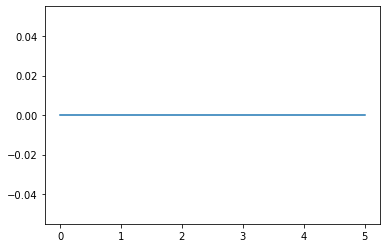

In [44]:
c.dtype

dtype('float64')

In [47]:
blocks_per_thread_x

5

In [54]:
@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[ty, tx] = 0
        sB[ty, tx] = 0
        if y < A.shape[0] and (tx+i*TPB) < A.shape[1]:
          sA[ty, tx] = A[y, tx + i * TPB]
        if x < B.shape[1] and (ty+i*TPB) < B.shape[0]:
          sB[ty, tx] = B[ty + i * TPB, x]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[ty, j] * sB[j, tx]

        # Wait until all threads finish computing
        cuda.syncthreads()
    if y < C.shape[0] and x < C.shape[1]:
        C[y, x] = tmp



#%%

k = 7
n = 2**k
m = 2**k
a = np.ones(n*m).reshape((n,m))
b = np.ones(n*m).reshape((n,m))
c = np.zeros((a.shape[0], b.shape[1]))

x_h = a
y_h = b
z_h = c

x_d = cuda.to_device(x_h)
y_d = cuda.to_device(y_h)
z_d = cuda.to_device(z_h)

#TPB must be an integer between 1 and 32
TPB = 32
threadsperblock = (TPB, TPB)
grid_y_max = max(x_h.shape[0],y_h.shape[0])
grid_x_max = max(x_h.shape[1],y_h.shape[1])
blockspergrid_x = math.ceil(grid_x_max / threadsperblock[0])
blockspergrid_y = math.ceil(grid_y_max / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

fast_matmul[blockspergrid, threadsperblock](x_d, y_d, z_d)
z_h = z_d.copy_to_host()
print(z_h)
print(x_h@y_h)

[[128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]
 ...
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]]
[[128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]
 ...
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]]


In [55]:
(z_h - a.dot(b)).max()

0.0